In [1]:
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.scipy.stats as stats
import jax.random as jr

import blackjax

from itertools import count
from functools import partial

from dynamax.parameters import to_unconstrained, from_unconstrained, log_det_jac_constrain
from dynamax.utils.utils import pytree_stack, ensure_array_has_batch_dim
from dynamax.linear_gaussian_ssm import LinearGaussianSSM

from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

In [2]:
# Simulate synthetic data from true model
state_dim = 2
emission_dim = 1
num_timesteps = 100
keys = map(jr.PRNGKey, count())

true_model = LinearGaussianSSM(state_dim, emission_dim)
true_params, _ = true_model.initialize(next(keys))
true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps)

In [5]:
# Define test model
model = LinearGaussianSSM(state_dim, emission_dim)
initial_params, param_props = model.initialize(next(keys),
                                                      dynamics_weights=true_params.dynamics.weights,
                                                      dynamics_bias=true_params.dynamics.bias,
                                                      emission_weights=true_params.emissions.weights,
                                                      emission_bias=true_params.emissions.bias)

# Set some parameters to true values and mark as frozen
param_props.dynamics.weights.trainable = False
param_props.dynamics.bias.trainable = False
param_props.emissions.weights.trainable = False
param_props.emissions.bias.trainable = False

In [44]:
inputs = None
batch_emissions = ensure_array_has_batch_dim(emissions, model.emission_shape)
batch_inputs = ensure_array_has_batch_dim(inputs, model.inputs_shape)
initial_unc_params = to_unconstrained(initial_params, param_props)

# The log likelihood that the HMC samples from
def logdensity_fn(unc_params):
    params = from_unconstrained(unc_params, param_props)
    batch_lls = vmap(partial(model.marginal_log_prob, params))(batch_emissions, batch_inputs)
    lp = model.log_prior(params) + batch_lls.sum()
    lp += log_det_jac_constrain(params, param_props) 
    lp += 10 * jr.normal(jr.PRNGKey(0))
    return lp

In [ ]:
from jax.flatten_util import ravel_pytree
p, unravel_fn = ravel_pytree(initial_unc_params)
inv_mass_matrix = jnp.eye(p.shape[0])
num_integration_steps = 30
step_size = 1e-3

# hmc = blackjax.hmc(logdensity_fn, step_size, inv_mass_matrix, num_integration_steps)
# initial_state = hmc.init(initial_unc_params)
# hmc_kernel = jax.jit(hmc.step)

random_walk = blackjax.additive_step_random_walk(logdensity_fn, blackjax.mcmc.random_walk.normal(0.1))
initial_state = random_walk.init(initial_unc_params)
kernel = jax.jit(random_walk.step)

def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [50]:
initial_state

RWState(position=ParamsLGSSM(initial=ParamsLGSSMInitial(mean=Array([0., 0.], dtype=float32), cov=Array([0., 0., 0.], dtype=float32)), dynamics=ParamsLGSSMDynamics(weights=Array([[0.99, 0.  ],
       [0.  , 0.99]], dtype=float32), bias=Array([0., 0.], dtype=float32), input_weights=Array([], shape=(2, 0), dtype=float32), cov=Array([-1.1512926,  0.       , -1.1512926], dtype=float32)), emissions=ParamsLGSSMEmissions(weights=Array([[-0.78476596,  0.85644484]], dtype=float32), bias=Array([0.], dtype=float32), input_weights=Array([], shape=(1, 0), dtype=float32), cov=Array([-1.1512926], dtype=float32))), logdensity=Array(-86.888916, dtype=float32))

In [47]:
# initial_toy_params = jnp.array([0.0, 0.0, 0.0, 0.0])
# inv_mass_matrix = jnp.eye(initial_toy_params.shape[0])
# def toy_logdensity_fn(params):
#     return -jnp.sum((params) ** 2)
# toy_hmc = blackjax.hmc(toy_logdensity_fn, step_size, inv_mass_matrix, num_integration_steps)
# initial_state = toy_hmc.init(initial_toy_params)
# initial_state

In [48]:
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, kernel, initial_state, 10_000)
sampled_params = from_unconstrained(states.position, param_props)

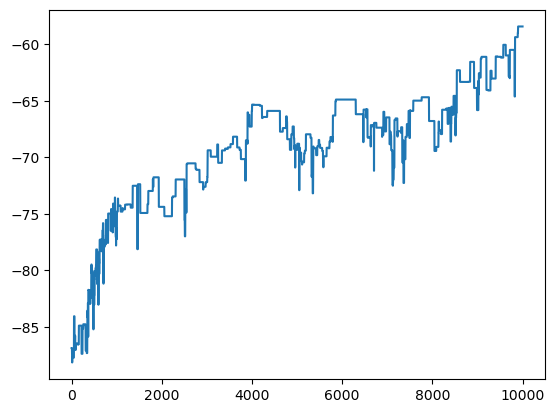

In [49]:
plt.plot(states.logdensity)
plt.show()